In [5]:
from Modular_code.utils import *
#from Modular_code.model import Model
#from Modular_code.train import train_epoch
#from Modular_code.val import val_epoch
from Modular_code.opts import *
from Modular_code.clr import OneCycle
from Modular_code.radam import RAdam

In [6]:
import pandas as pd
train_label = pd.read_csv(train_label_path)
valid_label = pd.read_csv(valid_label_path)
test_label = pd.read_csv(test_label_path)

In [7]:
train_id,train_classes = create_label(train_label,'./Output/Train') 
test_id,test_classes = create_label(test_label,'./Output/Test') 
valid_id,valid_classes = create_label(valid_label,'./Output/Validation') 

In [8]:
def extract_label(id,classes):
    id_new0 = []
    id_new1 = []
    
    for i,j in enumerate(classes):
        if(j == 0):
            id_new0.append(id[i])
        if(j == 1):
            id_new1.append(id[i])
    return id_new0,id_new1

In [9]:
train_id0,train_id1 = extract_label(train_id,train_classes) 
test_id0,test_id1 = extract_label(test_id,test_classes) 
valid_id0,valid_id1 = extract_label(valid_id,valid_classes) 

In [55]:
def lab(id0,id1):
    id = id0+id1
    classes = np.zeros((len(id0))).tolist() + np.ones((len(id1))).tolist()
    return id,classes

In [56]:
valid_id,valid_classes = lab(valid_id0,valid_id1)
test_id,test_classes = lab(test_id0,test_id1)

In [48]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
im_size = 112
class video_dataset(Dataset):
    def __init__(self,id,sequence_length = 60,label = None,transform = None):
        self.id =id
        self.engagement = label
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.id)
    def __getitem__(self,idx):
        video_path = self.id[idx]
        frames = []
        a = int(300/self.count)
        hp = np.random.randint(0,2)
        for frame in frame_extract(video_path):
            if(hp == 1):
                frame = cv2.flip(frame,1)
            frames.append(self.transform(frame))
        frames = torch.stack(frames)
        frames = frames[::a,:,:,:]
        frames = frames[:self.count]
#        frames = frames.reshape(self.count,3,im_size,im_size)
        if(self.engagement):
            label = self.engagement[idx]
            return frames,label
        return frames

In [36]:
im_size = 112
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

train_data_0 = video_dataset(train_id0,sequence_length = 100,transform = train_transforms)
train_data_1 = video_dataset(train_id1,sequence_length = 100,transform = train_transforms)


In [57]:
val_data = video_dataset(valid_id,sequence_length = 100,label = valid_classes,transform = train_transforms)
test_data = video_dataset(test_id,sequence_length = 100,label = test_classes,transform = train_transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


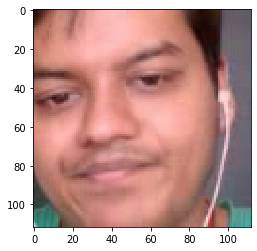

In [16]:
import cv2
import random
image = train_data_0[10]
im_plot(image[10,:,:,:])

In [103]:
#!git clone https://github.com/ndrplz/ConvLSTM_pytorch
from ConvLSTM_pytorch.convlstm import ConvLSTM
size = 4
import torchvision.models.resnet as resnet
import torch

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        block = resnet.BasicBlock
        layers=[3, 4, 23, 3]
        num_classes = 7
        model = resnet.ResNet(block, layers, num_classes)
        model.load_state_dict(torch.load('./checkpoint.pth.tar'))
        modules= list(model.children())[:-2]
        model = nn.Sequential(*modules)
        for param in model.parameters():
            param.requires_grad = False
        self.model = model
        c1 = ConvLSTM(  input_size=(size,size),
                             input_dim=512,
                             hidden_dim=[128,512],
                             kernel_size=(3,3),
                             num_layers=2,
                             batch_first = True,
                             bias=True,
                             return_all_layers = False)
        self.c1 = c1
        self.f1 = nn.Linear(512*size*size,512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512,32)
        self.fc3 = nn.Linear(32,1)
        self.dp = nn.Dropout(0.5)
        self.sig = nn.Sigmoid()
    def forward(self, input):
        x = self.model(input)
        x = x.view(-1,100,512,size,size).detach()
        x = self.c1(x)
        x = torch.mean(x[0][0],dim = 1)
        #x = x[0][0][:,-1,:,:,:]
        x = x.view(-1,512*size*size).detach()
        x = self.dp(self.relu(self.f1(x)))
        x = self.dp(self.relu(self.fc2(x)))
        x = self.sig(self.fc3(x))
        return x
model = Model().to('cuda')
model = nn.DataParallel(model)
#model.load_state_dict(torch.load('./results/emotionnet-50-0,1-hl/save.pth')['state_dict'])

In [12]:
import numpy as np
im_size = 112
model(torch.from_numpy(np.empty((200,3,im_size,im_size))).type(torch.cuda.FloatTensor))

torch.Size([50, 512, 4, 4])
torch.Size([50, 512, 4, 4])
torch.Size([50, 512, 4, 4])
torch.Size([50, 512, 4, 4])


tensor([[0.0436, 0.0000],
        [0.0493, 0.0000],
        [0.0444, 0.0641],
        [0.0435, 0.0680]], device='cuda:0', grad_fn=<GatherBackward>)

In [18]:
arch = 'emotionnet-50-0,1-hl'
result_path = os.path.join('./results',arch)
from tensorboardX import SummaryWriter
writer = SummaryWriter()
os.makedirs(result_path,exist_ok = True)
train_logger = Logger(
            os.path.join(result_path, 'train{}.log'.format(arch)),
            ['epoch', 'loss', 'acc', 'lr'])
train_batch_logger = Logger(
            os.path.join(result_path, 'train_batch{}.log'.format(arch)),
            ['epoch', 'batch', 'iter', 'loss', 'acc', 'lr'])    
val_logger = Logger(
            os.path.join(result_path, 'val{}.log'.format(arch)), ['epoch', 'loss', 'acc'])

In [104]:
batch_size = 16
train_loader_0 = DataLoader(train_data_0,batch_size = batch_size , num_workers = 16 ,shuffle = True)
train_loader_1 = DataLoader(train_data_1,batch_size = batch_size , num_workers = 16 ,shuffle = True)
val_loader = DataLoader(val_data,batch_size = batch_size , num_workers = 16)
test_loader = DataLoader(test_data,batch_size = batch_size , num_workers = 16)

In [20]:
def set_lr(optimizer, lr):
    for group in optimizer.param_groups:
        group['lr'] = lr

In [101]:
def hinge_loss(anom_pred, normal_pred):
    batch_size1 = len(anom_pred)
    batch_size2 = len(normal_pred)
    batch_size = min(batch_size1,batch_size2)
    loss = 0
    for j in range(batch_size):
        m1 = anom_pred[j]
        m2 = normal_pred[j]
        h = max(0,1-m2+m1)
        loss = loss+h
    return loss/batch_size

In [105]:
def calculate_accuracy1(outputs, targets):
    batch_size = targets.size(0)
    pred = outputs.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size
def test(epoch,model, data_loader ,criterion, result_path,best_acc = 0 , logger = None ):
    print('Testing')
    if(epoch == 1):
        best_acc = 0
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.cuda()
            inputs = inputs.cuda()
        inputs = Variable(inputs)
        targets = Variable(targets)
        if(inputs.size(0) < 16):
            continue
        with torch.no_grad():
            inputs = inputs.reshape(-1,3,im_size,im_size)  
        outputs = model(inputs.type(torch.cuda.FloatTensor))
        loss = criterion(outputs, targets)
        outputs[outputs>0.5] = 1
        outputs[outputs<=0.5] = 0
        acc = calculate_accuracy1(outputs, targets.type(torch.cuda.FloatTensor))
        
        true += targets.detach().cpu().numpy().reshape(len(targets)).tolist()
        pred += outputs.detach().cpu().numpy().reshape(len(outputs)).tolist()
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        sys.stdout.write(
                "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                % (
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg
                    )
                )
    if(logger):
        logger.log({'epoch': epoch, 'loss': losses.avg, 'acc': accuracies.avg})
    print('\nAccuracy {}'.format(accuracies.avg))
    if(accuracies.avg>best_acc):
        best_acc = accuracies.avg
        result_path = os.path.join(result_path,'best.pth')
        state = {
        'acc':best_acc,
         'state':model.state_dict()
        }
        torch.save(state,result_path)
    return true,pred,best_acc

In [ ]:
num_epochs = 100
count_0 = 0
count_1 = 0
it_0 = iter(train_loader_0)
it_1 = iter(train_loader_1)
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
im_size = 112
lr = 5e-3
best_acc = 0
optimizer = RAdam(model.parameters(), lr= lr , weight_decay = 1e-3)
import sys
for epoch in range(num_epochs):
    print('')
    print("--- Epoch {} ---".format(epoch))
    phase1 = ['train']
    for phase in phase1:
        print('')
        print("--- Phase {} ---".format(phase))
        epoch_metrics = {"loss": [], "hl":[]}
        batch_i = 0
        if(phase == 'train'):
            model = model.train()
        else:
            model = model.eval()
        for j in range(100):
            optimizer.zero_grad()
            batch = []
            if(count_0%len(train_loader_0) == 0 and count_0 !=0):
                it_0 = iter(train_loader_0)
                count_0 = 0
            if(count_1%len(train_loader_1) == 0 and count_1 !=0):
                it_1 = iter(train_loader_1)
                count_1 = 0
            images_0 = next(it_0)
            with torch.no_grad():
                images_0 = images_0.reshape(-1,3,im_size,im_size)
            if(images_0.size(0)%400 == 0):
                it_0 = iter(train_loader_0)
                predictions_0 = model(images_0.type(torch.cuda.FloatTensor))
            else:
                continue
            count_0 += 1
            count_1 += 1
            del images_0
            images_1 = next(it_1)
            with torch.no_grad():
                images_1 = images_1.reshape(-1,3,im_size,im_size)

            if(images_1.size(0)%400 == 0):
                predictions_1 = model(images_1.type(torch.cuda.FloatTensor))
            else:
                continue
            del images_1
            loss = hinge_loss(predictions_0,predictions_1)
            loss.cuda().backward()
            del predictions_0,predictions_1
            optimizer.step()
            epoch_metrics["loss"].append(loss.item())
            sys.stdout.write(
                  "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
                  % (
                      epoch,
                      num_epochs,
                      j,
                      100,
                      loss.item(),
                      np.mean(epoch_metrics["loss"])
                  )
              )
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            batch_i += 1
    save_file_path = os.path.join(result_path,'save.pth')
    states = {
        'state_dict': model.state_dict()
    }
    torch.save(states, save_file_path)
    true,pred,b = test(0,model,val_loader,hinge_loss,result_path,0)
    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(true,pred))

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sanjaymoto75/.conda/envs/env/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/home/sanjaymoto75/.conda/envs/env/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
Traceback (most recent call last):
  File "/home/sanjaymoto75/.conda/envs/env/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/home/sanjaymoto75/.conda/envs/env/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/sanjaymoto75/.conda/envs/env/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
  File "/home/sanjaymoto75/.conda/envs/env/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
  File "/home/sanjaymoto75/.conda/envs/env/lib/python3.7/multiprocessing/queues.py", line 232, in _feed



--- Epoch 0 ---

--- Phase train ---


  File "/home/sanjaymoto75/.conda/envs/env/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


[Epoch 0/100] [Batch 99/100] [Loss: 0.433223 (0.453551)]Testing
[Batch 9 / 11]  [Loss: 1.052781, Acc: 80.62%]
Accuracy 80.625
[[  2  21]
 [ 10 127]]

--- Epoch 1 ---

--- Phase train ---
[Epoch 1/100] [Batch 21/100] [Loss: 0.690041 (0.424357)]

In [ ]:
#model.load_state_dict(torch.load('./results/res50-150-3/save.pth')['state_dict'])